### Final script

Columns in dfA but not in dfB: {'revenue_ci_x', 'area_y', 'road_count', 'Unnamed: 0_x', 'area', 'revenue_ci_y.1', 'district_1', 'HQ', 'are_new_x', 'Unnamed: 0_y', 'district_1_y', 'district_3_x', 'area_x', 'are_new_y', 'count_x', 'are_new', 'mean_sexratio', 'district_3_y.1', 'revenue_cr', 'revenue_cr_y', 'revenue_cr_x', 'district_1_x', 'HQ_x', 'district_3_y', 'revenue_ci_y', 'HQ_y', 'district_3_x.1', 'revenue_ci_x.1', 'count_y'}
Columns in dfB but not in dfA: {'mean_sex_ratio', 'Female_Camp', 'object_id_new', 'Male_Camp', 'SDRF_sanctions_awarded_value', 'revenue_ci', 'Human_Live_Lost_Male', 'dtcode11', 'Human_Live_Lost_Female', 'Children_Camp', 'landd_score', 'dtname', 'Human_Live_Lost_Children'}
Column Data Type Comparison: {'slope_mean': (dtype('float64'), dtype('float64')), 'elevation_mean': (dtype('float64'), dtype('float64')), 'distance_from_river': (dtype('float64'), dtype('float64')), 'Human_Live_Lost': (dtype('int64'), dtype('int64')), 'Total_House_Fully_Damaged': (dtype('float6

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


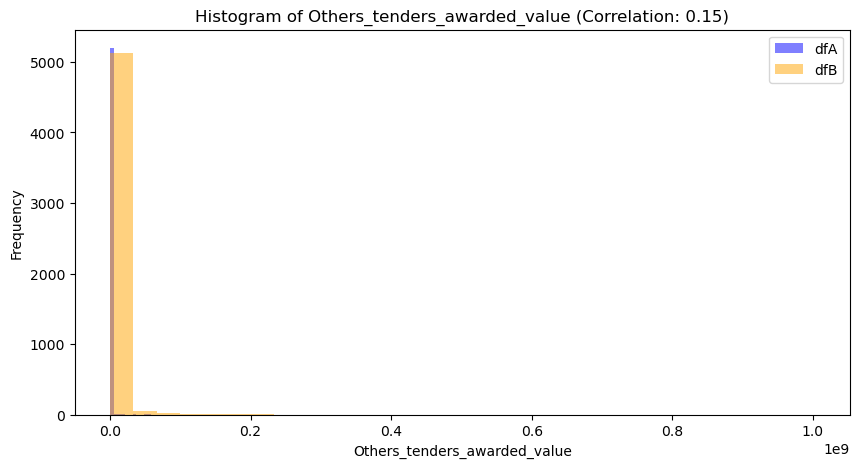

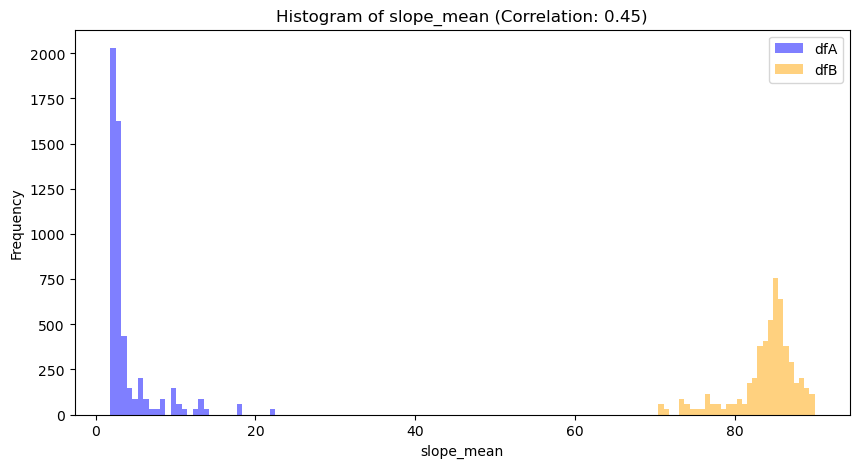

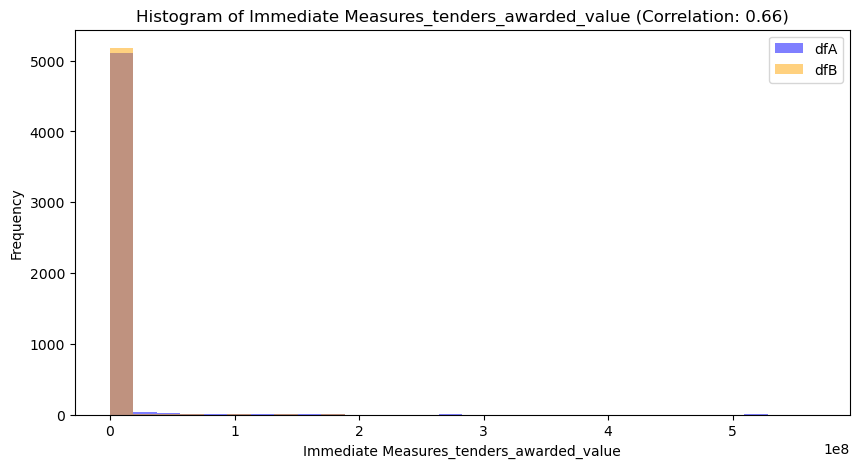

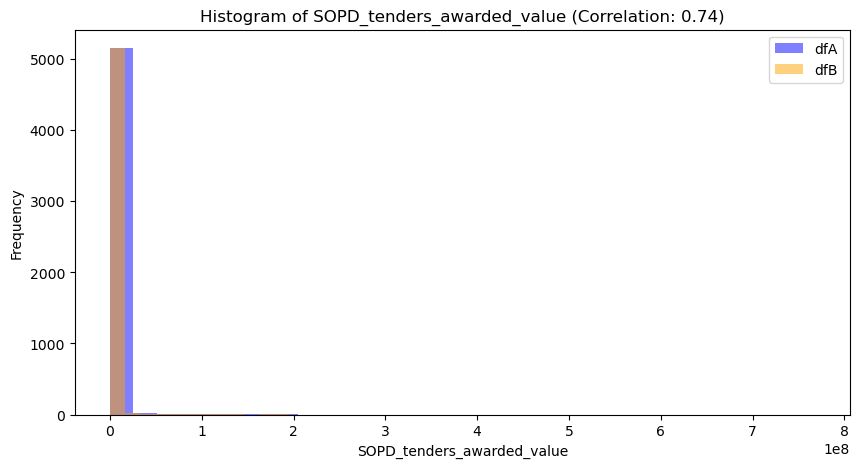

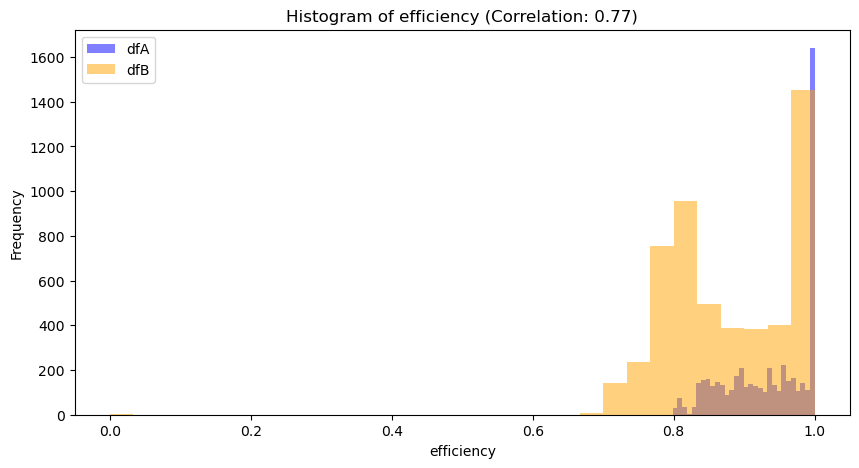

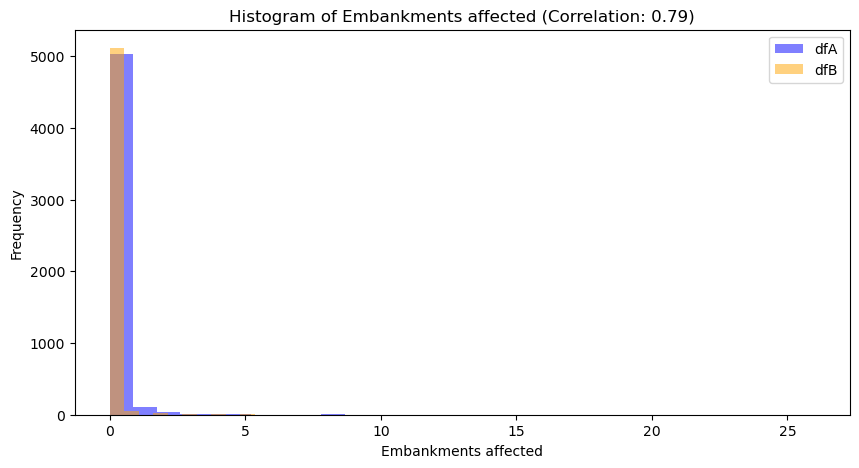

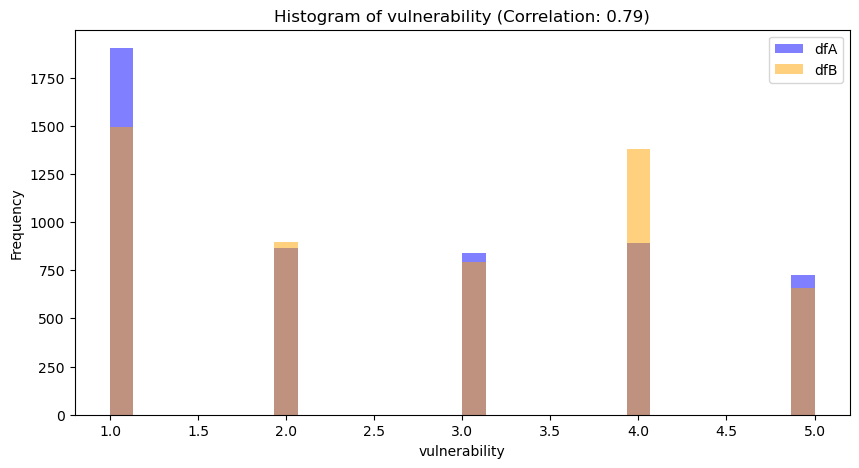

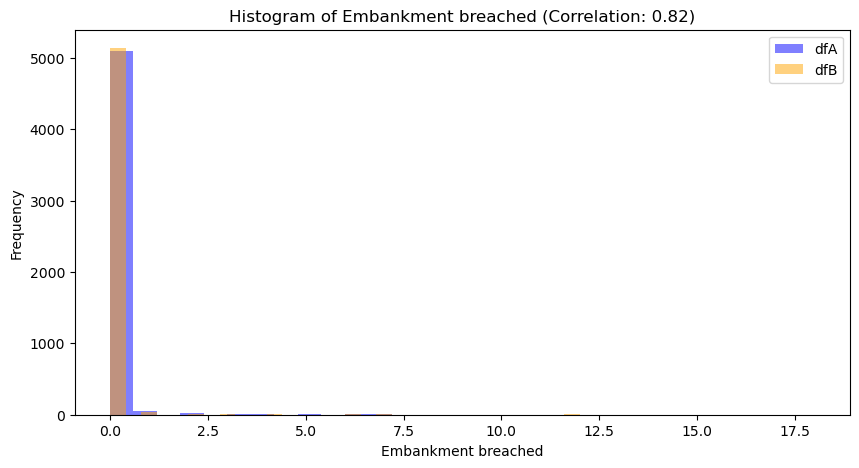

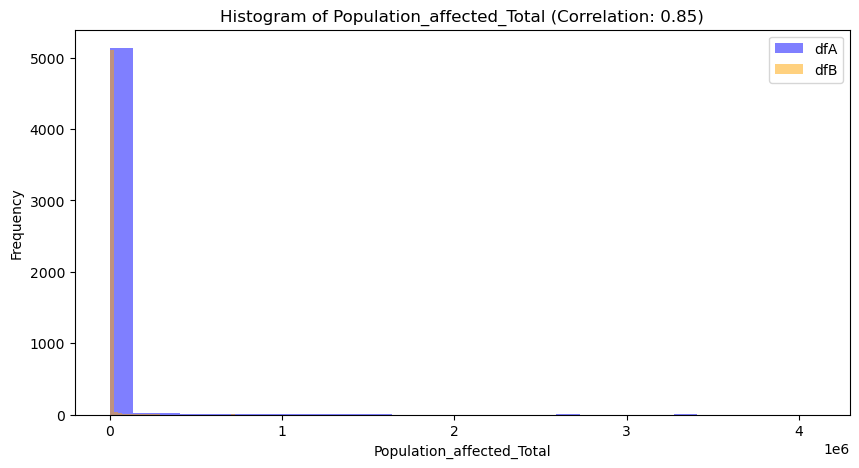

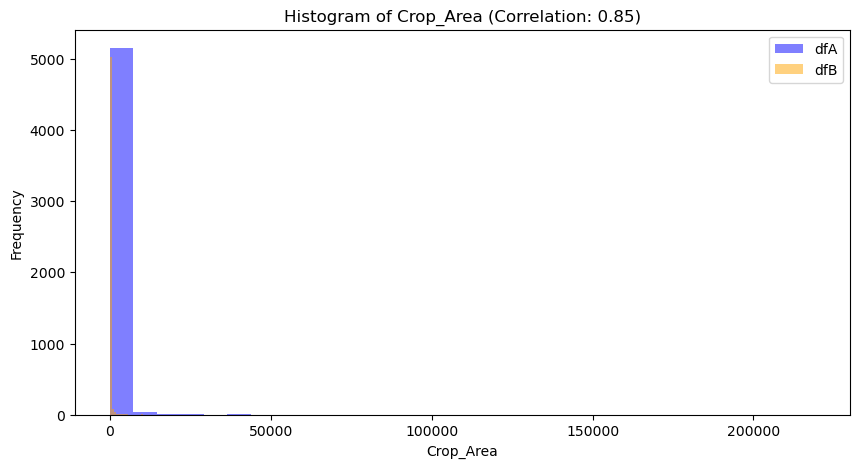

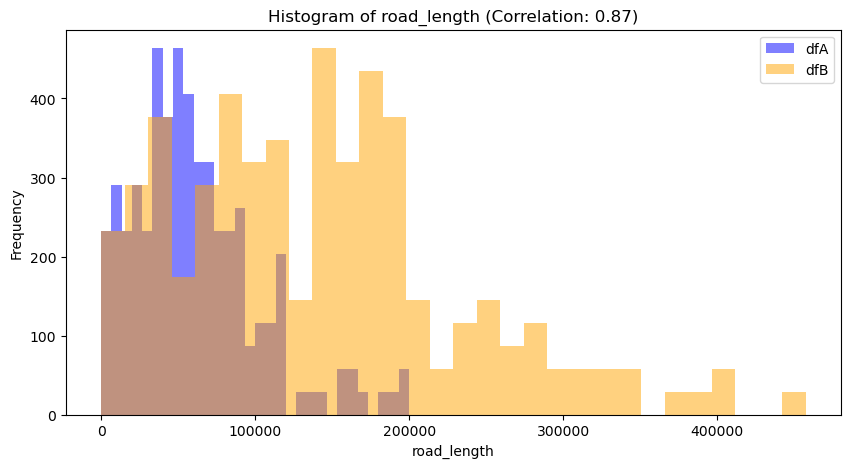

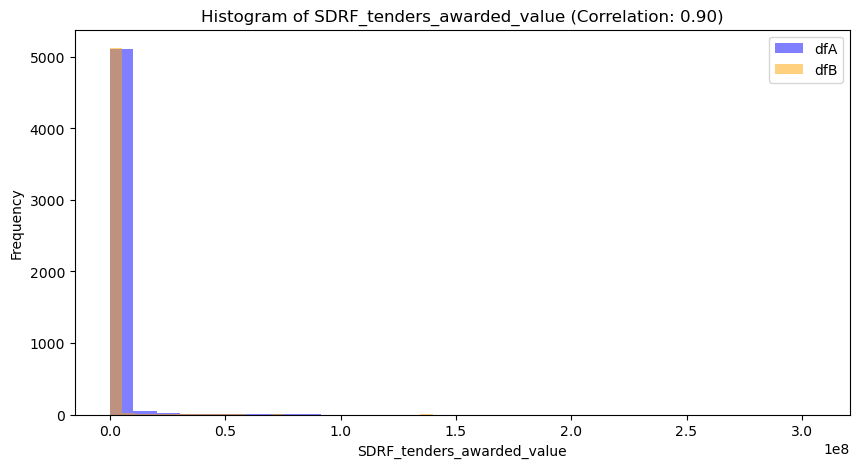

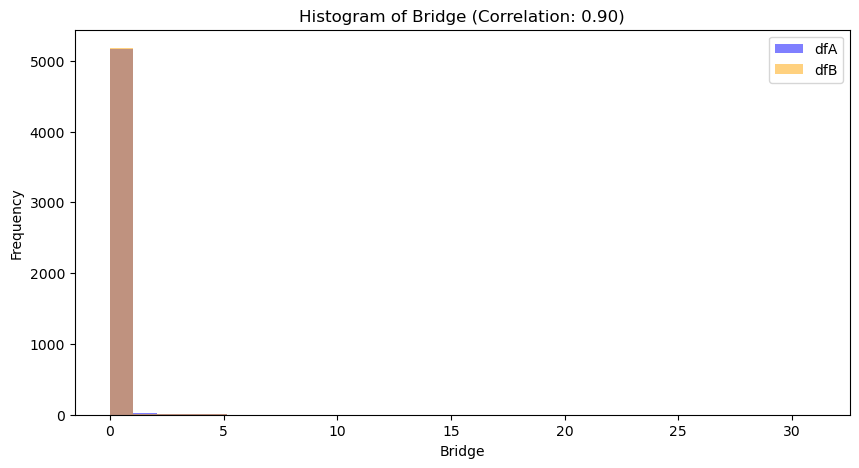

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency
import numpy as np

# Load Data

dfA = pd.read_csv(r"C:\Users\saura\Downloads\factor_scores_l1_vulnerability.csv")
dfB = pd.read_csv(r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\factor_scores_l1_vulnerability.csv")

# Preprocessing
dfB['object_id_old'] = dfB['object_id'].str[9:13]
dfB = dfB.rename(columns={'object_id': 'object_id_new', 'object_id_old': 'object_id'})
dates = ['2023_09', '2023_10',
         '2023_11',
         '2023_12',
         '2024_01',
         '2024_02',
         '2024_03',
         '2024_04',
         '2024_05',
         '2024_06',
         '2024_07',
         '2024_08',
         '2024_09',
         '2024_10',
         '2024_11',
         '2024_12']
dfB = dfB[~dfB['timeperiod'].isin(dates)]
dfB['object_id'] = dfB['object_id'].astype(int)

# Compare Column Names
missing_in_dfB = set(dfA.columns) - set(dfB.columns)
missing_in_dfA = set(dfB.columns) - set(dfA.columns)

print("Columns in dfA but not in dfB:", missing_in_dfB)
print("Columns in dfB but not in dfA:", missing_in_dfA)

shared_columns = set(dfA.columns) & set(dfB.columns)
dtype_comparison = {col: (dfA[col].dtype, dfB[col].dtype) for col in shared_columns}
print("Column Data Type Comparison:", dtype_comparison)

# Filter shared columns with matching data types
shared_columns = {col for col in shared_columns if dtype_comparison[col][0] == dtype_comparison[col][1]}
dfB = dfB.sort_values(by=['object_id', 'timeperiod']).reset_index(drop=True)
dfA = dfA.sort_values(by=['object_id', 'timeperiod']).reset_index(drop=True)

# Correlation and Overlap Calculations
column_comparison = {}

for col in shared_columns:
    if np.issubdtype(dfA[col].dtype, np.number):  # Numeric columns
        correlation = dfA[col].corr(dfB[col])
        column_comparison[col] = {
            'type': 'numeric',
            'correlation': correlation
        }
        print(f"Correlation for {col}: {correlation}")
    else:  # Categorical or non-numeric columns
        overlap = len(set(dfA[col]) & set(dfB[col])) / len(set(dfA[col]) | set(dfB[col]))
        column_comparison[col] = {
            'type': 'categorical',
            'overlap': overlap
        }
        print(f"Overlap for {col}: {overlap}")

# Plot histograms for low correlation columns
low_correlation_columns = [col for col, stats in column_comparison.items() if stats['type'] == 'numeric' and abs(stats['correlation']) < 0.9]
low_correlation_columns = sorted(low_correlation_columns, key=lambda col: abs(column_comparison[col]['correlation']))
for col in low_correlation_columns:
    plt.figure(figsize=(10, 5))
    plt.hist(dfA[col].dropna(), bins=30, alpha=0.5, label='dfA', color='blue')
    plt.hist(dfB[col].dropna(), bins=30, alpha=0.5, label='dfB', color='orange')
    plt.title(f'Histogram of {col} (Correlation: {column_comparison[col]["correlation"]:.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


### Steps

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp, chi2_contingency1
import numpy as np

ImportError: cannot import name 'chi2_contingency1' from 'scipy.stats' (c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\scipy\stats\__init__.py)

In [121]:
dfA = pd.read_csv(r"C:\Users\saura\Downloads\factor_scores_l1_vulnerability.csv")
dfB = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Deployment\IDS-DRR-Assam-Risk-Model\RiskScoreModel\data\factor_scores_l1_vulnerability.csv')


In [ ]:
dfB['object_id_old'] = dfB['object_id'].str[9:13]
dfB = dfB.rename(columns={'object_id':'object_id_new','object_id_old':'object_id'})
dates = ['2023_09','2023_10',
 '2023_11',
 '2023_12',
 '2024_01',
 '2024_02',
 '2024_03',
 '2024_04',
 '2024_05',
 '2024_06',
 '2024_07',
 '2024_08',
 '2024_09',
 '2024_10',
 '2024_11',
 '2024_12']
dfB = dfB[~dfB['timeperiod'].isin(dates)]
dfB['object_id'] = dfB['object_id'].astype(int)

In [123]:
# Comparing columns and structure
missing_in_dfB = set(dfA.columns) - set(dfB.columns)
missing_in_dfA = set(dfB.columns) - set(dfA.columns)

print("Columns in dfA but not in dfB:", missing_in_dfB)
print("Columns in dfB but not in dfA:", missing_in_dfA)


Columns in dfA but not in dfB: {'revenue_ci_x', 'area_y', 'road_count', 'Unnamed: 0_x', 'area', 'revenue_ci_y.1', 'district_1', 'HQ', 'are_new_x', 'Unnamed: 0_y', 'district_1_y', 'district_3_x', 'area_x', 'are_new_y', 'count_x', 'are_new', 'mean_sexratio', 'district_3_y.1', 'revenue_cr', 'revenue_cr_y', 'revenue_cr_x', 'district_1_x', 'HQ_x', 'district_3_y', 'revenue_ci_y', 'HQ_y', 'district_3_x.1', 'revenue_ci_x.1', 'count_y'}
Columns in dfB but not in dfA: {'mean_sex_ratio', 'Female_Camp', 'object_id_new', 'Male_Camp', 'SDRF_sanctions_awarded_value', 'revenue_ci', 'Human_Live_Lost_Male', 'dtcode11', 'Human_Live_Lost_Female', 'Children_Camp', 'landd_score', 'dtname', 'Human_Live_Lost_Children'}


In [124]:
shared_columns = set(dfA.columns) & set(dfB.columns)
dtype_comparison = {col: (dfA[col].dtype, dfB[col].dtype) for col in shared_columns}
print("Column Data Type Comparison:", dtype_comparison)

Column Data Type Comparison: {'slope_mean': (dtype('float64'), dtype('float64')), 'elevation_mean': (dtype('float64'), dtype('float64')), 'distance_from_river': (dtype('float64'), dtype('float64')), 'Human_Live_Lost': (dtype('int64'), dtype('int64')), 'Total_House_Fully_Damaged': (dtype('float64'), dtype('float64')), 'count': (dtype('float64'), dtype('float64')), 'CIDF_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'inundation_intensity_sum': (dtype('float64'), dtype('float64')), 'LTIF_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'max_rain': (dtype('float64'), dtype('float64')), 'built_area': (dtype('float64'), dtype('float64')), 'avg_tele': (dtype('float64'), dtype('float64')), 'RIDF_tenders_awarded_value': (dtype('float64'), dtype('float64')), 'inundation_intensity_mean': (dtype('float64'), dtype('float64')), 'Population_affected_Total': (dtype('float64'), dtype('float64')), 'crops': (dtype('float64'), dtype('float64')), 'Others_tenders_awarded_value':

In [131]:
shared_columns = {col for col in shared_columns if dtype_comparison[col][0] == dtype_comparison[col][1]}
dfB = dfB.sort_values(by=['object_id', 'timeperiod']).reset_index(drop=True)
dfA = dfA.sort_values(by=[ 'object_id','timeperiod']).reset_index(drop=True)

for col in shared_columns:    

    if np.issubdtype(dfA[col].dtype, np.number):  # Numeric columns
        correlation = dfA[col].corr(dfB[col])
        print(f"Correlation for {col}: {correlation}")
    else:  # Categorical or non-numeric columns
        overlap = len(set(dfA[col]) & set(dfB[col])) / len(set(dfA[col]) | set(dfB[col]))
        print(f"Overlap for {col}: {overlap}")


Correlation for slope_mean: 0.45050550072213286
Correlation for distance_from_river: 0.9999999999999999
Correlation for elevation_mean: 1.0
Correlation for Human_Live_Lost: 0.9683933598401319
Correlation for Total_House_Fully_Damaged: 1.0
Correlation for count: 0.9999999999999999
Correlation for CIDF_tenders_awarded_value: 1.0
Correlation for inundation_intensity_sum: 1.0
Correlation for LTIF_tenders_awarded_value: nan
Correlation for max_rain: 0.9999999999999999
Correlation for built_area: 1.0
Correlation for avg_tele: 1.0
Correlation for RIDF_tenders_awarded_value: 0.9125371854894511
Correlation for inundation_intensity_mean: 1.0
Correlation for Population_affected_Total: 0.8486850566772202
Correlation for crops: 0.9999999999999998
Correlation for Others_tenders_awarded_value: 0.1515958790765434
Correlation for Embankment breached: 0.818932059632962
Correlation for sum_rain: 0.9999999999999999
Correlation for sum_young_population: 0.9134330884163638
Correlation for rc_piped_hhds_pct:

c:\Users\saura\anaconda3\envs\cdl-env\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


In [ ]:

# 4. Plot histograms for low correlation columns
low_correlation_columns = [col for col, stats in column_comparison.items() if stats['type'] == 'numeric' and abs(stats['correlation']) < 0.9]

for col in low_correlation_columns:
plt.figure(figsize=(10, 5))
plt.hist(dfA[col].dropna(), bins=30, alpha=0.5, label='dfA', color='blue')
plt.hist(dfB[col].dropna(), bins=30, alpha=0.5, label='dfB', color='orange')
plt.title(f'Histogram of {col} (Correlation: {column_comparison[col]["correlation"]:.2f})')
plt.xlabel(col)
plt.ylabel('Frequency')
plt.legend()                                                                            
plt.show()

,object_id_new,district,rc_area,timeperiod,total_tender_awarded_value,SOPD_tenders_awarded_value,SDRF_sanctions_awarded_value,SDRF_tenders_awarded_value,RIDF_tenders_awarded_value,LTIF_tenders_awarded_value,...,avg_tele,rc_piped_hhds_pct,rc_nosanitation_hhds_pct,total_hhd,distance_from_river,drainage_density,efficiency,vulnerability,landd_score,object_id
0,18-300-00101,KOKRAJHAR,1069,2021_04,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
1,18-300-00101,KOKRAJHAR,1069,2021_05,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
2,18-300-00101,KOKRAJHAR,1069,2021_06,8544502.0,8544502.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
3,18-300-00101,KOKRAJHAR,1069,2021_07,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
4,18-300-00101,KOKRAJHAR,1069,2021_08,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.947538,20.156822,62460.0,1718.766638,0.000542,0.727241,5,1.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7719,18-760-00281,MAJULI,648,2023_04,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.974326,1,1.000000,281
7720,18-760-00281,MAJULI,648,2023_05,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.974326,1,1.000000,281
7721,18-760-00281,MAJULI,648,2023_06,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.793474,4,1.000309,281
7722,18-760-00281,MAJULI,648,2023_07,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,7.813776,6.202922,22038.0,822.878713,0.000629,0.762981,4,1.056178,281
